In [1]:
import os, cv2
import open3d as o3d
import numpy as np
from util import parseMKV, exportCalib, tcp2base, target2cam_depth, composeH, dumpTrajectoryLogs, deconstructPoses
from visualizer import CameraPoseVisualizer
from scipy.spatial.transform import Rotation

os.chdir(globals()['_dh'][0])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
dir = "./geo0"
out_dir = "./calib"

debug = True
matForm = False

dumpTrajectories = True
exportCalibration = True
exportRobotPose = True
exportPoseEstimation = True

methods_s = ["tsai"]#, "park", "horaud", "andreff", "daniilidis"]

In [3]:
cam2tcp_color = np.load("%s/_cam2tcp_color.npz" % out_dir)

if exportCalibration:
    mtx, dist = exportCalib(dir = dir, debug = debug)
else:
    data = np.load("%s/calibration.npz" % dir)
    
    mtx = data["mtx"]
    dist = data["dist"]

if exportRobotPose:
    t_tcp2base, rVec_tcp2base, rMat_tcp2base, q_tcp2base = tcp2base(dir = dir)
else:
    data = np.load("%s/tcp2base.npz" % dir)

    t_tcp2base = data["t"]
    rVec_tcp2base = data["rVec"]
    rMat_tcp2base = data["rMat"]
    q_tcp2base = data["q"]

if dumpTrajectories:
    traj, H_cam2base = dumpTrajectoryLogs(dir, t_tcp2base, rMat_tcp2base, cam2tcp_color, methods_s)


if exportPoseEstimation:
    est_pose, fitness, pinhole_extrinsics = target2cam_depth(dir = dir,
                                         trajectory = traj,
                                         methods = methods_s,
                                         debug = debug)
else:
    est_pose = np.load("%s/est_pose.npy" % dir, allow_pickle=True).item()
    fitness = np.load("%s/fitness.npy" % dir, allow_pickle=True).item()
    pinhole_extrinsics = np.load("%s/pinhole_extr.npy" % dir, allow_pickle=True).item()

Camera Matrix:
 [[1949.5269775390625, 0.0, 2038.583251953125], [0.0, 1948.865966796875, 1558.489013671875], [0.0, 0.0, 1.0]]
Distortion Coefficients:
 [0.5040435194969177, -2.6585097312927246, 0.0013027479872107506, -0.0005786155234090984, 1.516607642173767, 0.3857000470161438, -2.4865224361419678, 1.4463715553283691]
-----Pose #0 | Method:tsai-----
RegistrationResult with fitness=9.379323e-01, inlier_rmse=1.099178e-03, and correspondence_set size of 1706353
Access transformation to get result.
Transformation:
[[ 0.9998956   0.00240462 -0.01424777  0.01269202]
 [-0.00217697  0.99987007  0.01597176 -0.01520693]
 [ 0.01428432 -0.01593908  0.99977093 -0.02367485]
 [ 0.          0.          0.          1.        ]]
Input Pose:
[[-0.20622303 -0.92340727  0.32371451  0.74245179]
 [-0.86063842  0.01375648 -0.50903072  0.37908076]
 [ 0.46558949 -0.383575   -0.79755667  0.96643972]
 [ 0.          0.          0.          1.        ]]
Estimated Pose:
[[-0.19767729 -0.92881993  0.3133963   0.74296

In [6]:
methods = [cv2.CALIB_HAND_EYE_TSAI, cv2.CALIB_HAND_EYE_PARK, cv2.CALIB_HAND_EYE_HORAUD, cv2.CALIB_HAND_EYE_ANDREFF, cv2.CALIB_HAND_EYE_DANIILIDIS]

R_results = []
t_results = []

for i in range(len(methods_s)):
    cur_method = methods_s[i]

    T_pose, R_pose = deconstructPoses(est_pose.get(cur_method))
    t_cam2base, R_cam2base = deconstructPoses(pinhole_extrinsics.get(cur_method))#, scale = 1000.0)

    cur_fitness = np.asarray(fitness.get(cur_method))
    failedIdx = np.where(cur_fitness < .8)

    T_pose = np.delete(T_pose, failedIdx, 0)
    R_pose = np.delete(R_pose, failedIdx, 0)

    t_cam2base = np.delete(t_cam2base, failedIdx, 0)
    R_cam2base = np.delete(R_cam2base, failedIdx, 0)

    print("--------------------------------------")
    print("Method %s" % methods_s[i])
    if(len(t_cam2base) <= 10):
        print("Not enough usable pose estimations!")
        R_results.append(np.eye(3))
        t_results.append(np.zeros((1,3)))
    else:
        try:
            R_cam2tcp, t_cam2tcp = cv2.calibrateHandEye(R_cam2base, t_cam2base, R_pose, T_pose, method=methods[i])
            R_results.append(R_cam2tcp)
            t_results.append(t_cam2tcp)
            # output results
            print("Rotation:\n", R_cam2tcp)
            print("Translation:\n", t_cam2tcp.ravel())

            cur_cam2tcp = composeH(R_cam2tcp, t_cam2tcp)
            cam2tcp_depth = cam2tcp_color[methods_s[i]]@cur_cam2tcp
            print("Saving Method: %s..." % methods_s[i], end="")
            np.save("%s/cam2tcp_%s_depth" % (out_dir, methods_s[i]), cam2tcp_depth)
            print("Done!")
        except:
            print("Method: %s failed!" % methods_s[i])
print("--------------------------------------")

# print("Saving All Methods...", end="")
# np.savez("%s/_cam2tcp_depth" % out_dir, tsai=cam2tcp_color[methods_s[0]]@composeH(R_results[0], t_results[0]),
#                                        park=cam2tcp_color[methods_s[1]]@composeH(R_results[1], t_results[1]),
#                                        horaud=cam2tcp_color[methods_s[2]]@composeH(R_results[2], t_results[2]),
#                                        andreff=cam2tcp_color[methods_s[3]]@composeH(R_results[3], t_results[3]),
#                                        daniilidis=cam2tcp_color[methods_s[4]]@composeH(R_results[4], t_results[4]))
# print("Done!")

--------------------------------------
Method tsai
Rotation:
 [[ 0.99991865  0.01081046 -0.00676978]
 [-0.01083754  0.99993337 -0.0039762 ]
 [ 0.00672635  0.00404925  0.99996918]]
Translation:
 [0. 0. 0.]
Saving Method: tsai...Done!
--------------------------------------


initialize camera pose visualizer


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
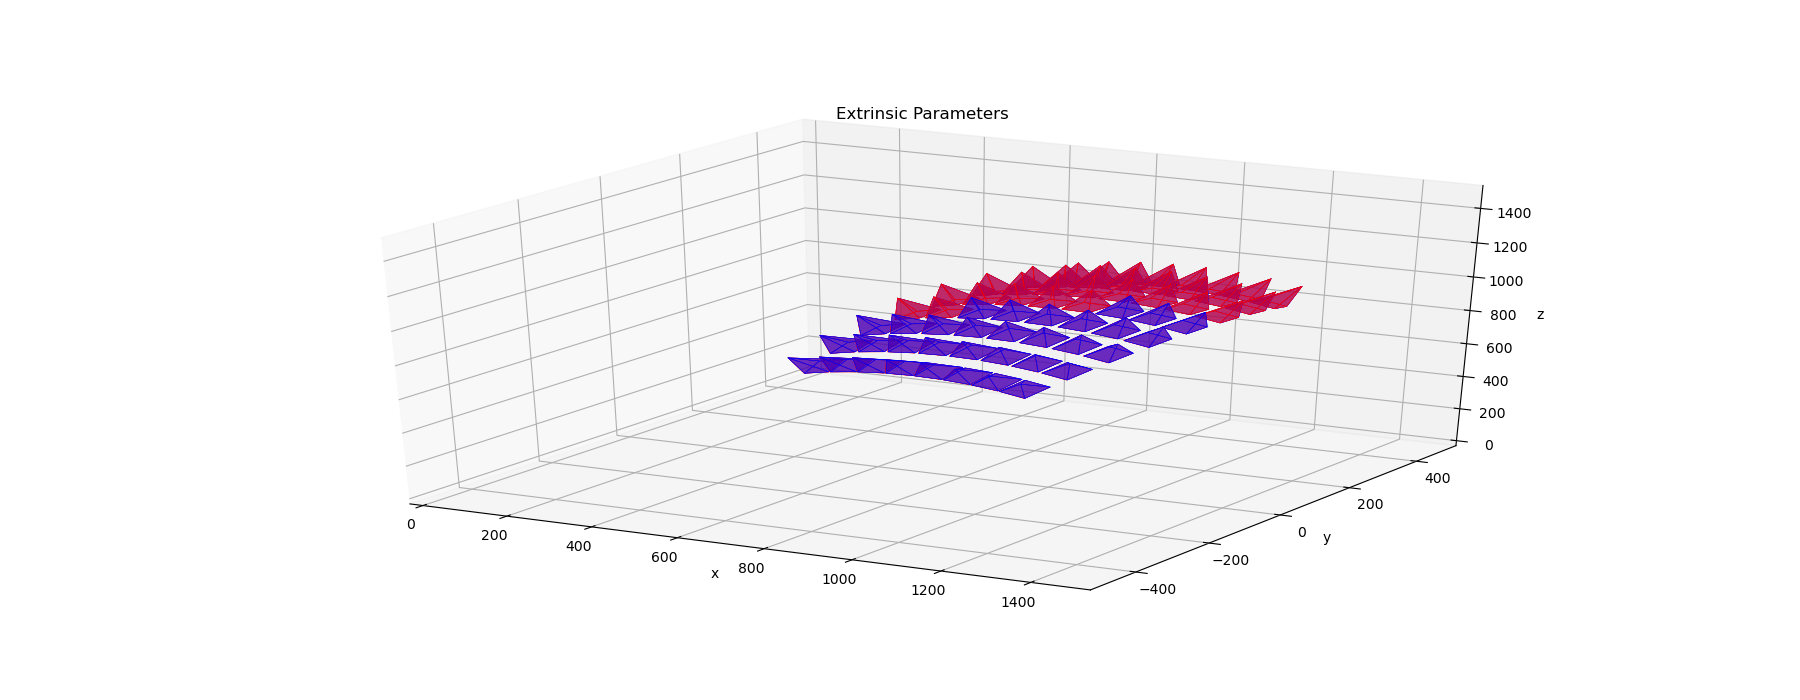

In [5]:
%matplotlib widget

handEyeMethod = 0

visualizer = CameraPoseVisualizer([0, 1500], [-500, 500], [0, 1500])

cam2base = []

M_cam2tcp = composeH(R_results[handEyeMethod], t_results[handEyeMethod])
for i in range(len(t_tcp2base)):
    M_tcp2base = composeH(rMat_tcp2base[i], t_tcp2base[i])
    M_cam2base = np.matmul(M_tcp2base,M_cam2tcp)

    cam2base.append(M_cam2base)

    visualizer.extrinsic2pyramid(M_tcp2base, 'r', 100)
    visualizer.extrinsic2pyramid(M_cam2base, 'b', 100)
visualizer.show()

np.savez("%s/%s" % (dir, "cam2base"), cam2base)